In [1]:
%matplotlib inline

import os
import pickle

IMG_PATH = "_img"
CACHE_PATH = "_cache"
if not os.path.isdir(IMG_PATH): os.mkdir(IMG_PATH)
if not os.path.isdir(CACHE_PATH): os.mkdir(CACHE_PATH)

import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy.stats import zscore

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(context="talk", style="ticks", palette="colorblind", color_codes=True)

from MaStarChecks.constants import STELLAR_LIBRARIES_PATH
from MaStarChecks.plotting import triang_plot

from sklearn.impute import KNNImputer
from sklearn.neighbors import LocalOutlierFactor
from sklearn.decomposition import PCA, KernelPCA
from sklearn.cluster import KMeans, MeanShift, SpectralClustering, DBSCAN
from sklearn import metrics

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV


PROCESSED_PATH = os.path.join(STELLAR_LIBRARIES_PATH, "processed-libraries")
Y_COLUMNS = ["TEFF", "LOGG", "MET"]

def cv_silhouette_scorer(estimator, X):
    estimator.fit(X)
    cluster_labels = estimator["cluster"].labels_
    num_labels = len(set(cluster_labels))
    num_samples = len(X.index)
    if num_labels <= 2 or (-1 in cluster_labels and num_labels <= 3) or num_labels == num_samples:
        return 0.0
    else:
        return 0.5 * (1+metrics.silhouette_score(X, cluster_labels, metric=estimator["cluster"].metric))

In [2]:
# _, _, _, X, y, _ = pickle.load(open(os.path.join(CACHE_PATH, "rs-wl_X_e_M_y_mastar_target.p"), "rb"))

# X = X.astype(float)
# y = y.astype(float)
# y["Teff"] = np.log10(y["Teff"])

CACHE_FEATURES = os.path.join(CACHE_PATH, "features-miles-indous.p")

if os.path.isfile(CACHE_FEATURES):
    X, catalogue = pickle.load(open(CACHE_FEATURES,"rb"))
else:
    miles_list = sorted([os.path.join(PROCESSED_PATH,fitsname) for fitsname in os.listdir(PROCESSED_PATH) if fitsname.startswith("processed-miles-") and fitsname.endswith("fits.gz")])
    indous_list = sorted([os.path.join(PROCESSED_PATH,fitsname) for fitsname in os.listdir(PROCESSED_PATH) if fitsname.startswith("processed-indous-") and fitsname.endswith("fits.gz")])

    miles_hdus = [fits.open(fitspath, memmap=False) for fitspath in miles_list]
    indous_hdus = [fits.open(fitspath, memmap=False) for fitspath in indous_list]

    miles_catalogue = extract_catalogue(miles_hdus, "MILES")
    miles_catalogue = miles_catalogue.mask(miles_catalogue==NAN_PLACEHOLDER)
    indous_catalogue = extract_catalogue(indous_hdus, "IndoUS")
    indous_catalogue = indous_catalogue.mask(indous_catalogue==NAN_PLACEHOLDER)

    miles_catalogue["LIBRARY"] = "MILES"
    indous_catalogue["LIBRARY"] = "IndoUS"

    miles_seds = extract_spectra(miles_hdus, "MILES")
    indous_seds = extract_spectra(indous_hdus, "IndoUS")

    X = pd.concat((miles_seds,indous_seds), axis="index", ignore_index=True, sort=False)
    X = fill_missing(X)

    catalogue = pd.concat((miles_catalogue,indous_catalogue), axis="index", ignore_index=True, sort=False)
    
    pickle.dump((X,catalogue), open(CACHE_FEATURES,"wb"))

y = catalogue.filter(items=Y_COLUMNS)
y.TEFF = np.log10(y.TEFF)

print(f"# SED         : {X.shape[0]}")
print(f"# wavelengths : {X.shape[1]}")

# SED         : 2246
# wavelengths : 6005


In [22]:
pipeline = Pipeline([
    ("reduction", PCA(n_components=0.95)),
    ("cluster", DBSCAN(eps=0.1, min_samples=20)),
])

parameters = {
#     "reduction__n_components": [2,3,4,5,10],
#     "reduction__kernel": ["linear", "poly", "rbf", "sigmoid", "cosine"],
#     "reduction__degree": [1,2,3,4,5,10],
#     "reduction__gamma": [0.001, 0.01, 0.1, 0.5, 0.7],
#     "cluster__eps": [0.005, 0.01, 0.05, 0.1, 0.5, 1.0, 2.0, 5.0],
#     "cluster__min_samples": [5, 10, 20, 30, 40, 50, 70, 100],
#     "cluster__metric": ['cityblock', 'cosine', 'euclidean', 'l1', 'l2', 'manhattan'],
#     "cluster__algorithm": ['auto', 'ball_tree', 'kd_tree', 'brute']
}
# cv = [(slice(None), slice(None))]
cv = [(np.arange(X.shape[0]), np.arange(X.shape[0]))]

grid_search = GridSearchCV(pipeline, parameters, scoring=cv_silhouette_scorer, cv=cv, n_jobs=1, verbose=3)
grid_search.fit(X)

Fitting 1 folds for each of 1 candidates, totalling 1 fits
[CV]  ................................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................................... , score=0.488, total=  25.8s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   25.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   25.9s finished


GridSearchCV(cv=[(array([   0,    1,    2, ..., 2243, 2244, 2245]),
                  array([   0,    1,    2, ..., 2243, 2244, 2245]))],
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('reduction',
                                        PCA(copy=True, iterated_power='auto',
                                            n_components=0.95,
                                            random_state=None,
                                            svd_solver='auto', tol=0.0,
                                            whiten=False)),
                                       ('cluster',
                                        DBSCAN(algorithm='auto', eps=0.1,
                                               leaf_size=30, metric='euclidean',
                                               metric_params=None,
                                               min_samples=20, n_jobs=None,
                                               p=

In [23]:
grid_search.best_params_, grid_search.best_score_

({}, 0.48757648248301283)

In [24]:
X_pca = grid_search.best_estimator_["reduction"].transform(X)
labels = grid_search.best_estimator_.fit_predict(X)
i_clusters = np.unique(labels)

In [25]:
print(f"clusters          = {i_clusters}")
print("METRICS IN PCA SPACE:")
print("---------------------")
print(f"silhouette        = {metrics.silhouette_score(X_pca, labels, metric=grid_search.best_estimator_['cluster'].metric):>10.2f} [-1: bad, 0: overlap, +1: good]")
print(f"calinski-harabasz = {metrics.calinski_harabasz_score(X_pca, labels):>10.2f} [small: bad, large: good]")
print(f"davies-bouldin    = {metrics.davies_bouldin_score(X_pca, labels):>10.2f} [0: good, >0: bad]")
print("METRICS IN ORI SPACE:")
print("---------------------")
print(f"silhouette        = {metrics.silhouette_score(X, labels, metric=grid_search.best_estimator_['cluster'].metric):>10.2f} [-1: bad, 0: overlap, +1: good]")
print(f"calinski-harabasz = {metrics.calinski_harabasz_score(X, labels):>10.2f} [small: bad, large: good]")
print(f"davies-bouldin    = {metrics.davies_bouldin_score(X, labels):>10.2f} [0: good, >0: bad]")

clusters          = [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
METRICS IN PCA SPACE:
---------------------
silhouette        =       0.37 [-1: bad, 0: overlap, +1: good]
calinski-harabasz =       1.27 [small: bad, large: good]
davies-bouldin    =       1.57 [0: good, >0: bad]
METRICS IN ORI SPACE:
---------------------
silhouette        =      -0.02 [-1: bad, 0: overlap, +1: good]
calinski-harabasz =       2.09 [small: bad, large: good]
davies-bouldin    =       1.79 [0: good, >0: bad]


In [26]:
X_pca_cluster = pd.DataFrame(index=X.index, columns=[f"pca_{i+1}" for i in range(grid_search.best_estimator_["reduction"].n_components_)], data=X_pca.copy())
X_pca_cluster["label"] = labels

y_cluster = y.copy()
y_cluster["label"] = [f"cluster # {label}" for label in labels]

X_cluster = X.copy()
X_cluster["label"] = labels

cluster_cent = []
for i in i_clusters:    
    cluster_mean = X_pca[X_cluster.label==i].mean(axis=0)
    cluster_cent.append(np.argmin(np.sqrt(((cluster_mean[None, :] - X_pca)**2).sum(axis=1)), axis=0))

X_cluster.label.value_counts().sort_index()

-1     633
 0     144
 1     125
 2     182
 3      30
 4     116
 5     110
 6      37
 7     168
 8      21
 9      91
 10    102
 11     82
 12     34
 13     61
 14     51
 15     58
 16     28
 17     28
 18     32
 19     56
 20     33
 21     24
Name: label, dtype: int64

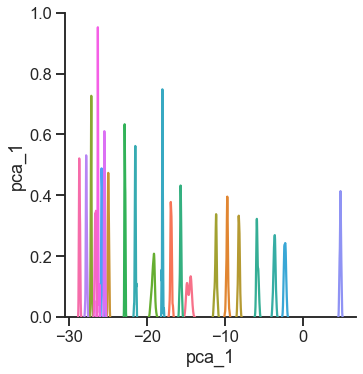

In [27]:
g = sns.PairGrid(X_pca_cluster[X_pca_cluster.label!=-1], diag_sharey=False, hue="label", height=5, vars=X_pca_cluster.drop(columns="label").columns.tolist())
g.map_diag(sns.kdeplot)
g.map_lower(plt.scatter)
for i, j in zip(*np.triu_indices_from(g.axes, 1)):
    g.axes[i, j].set_visible(False)

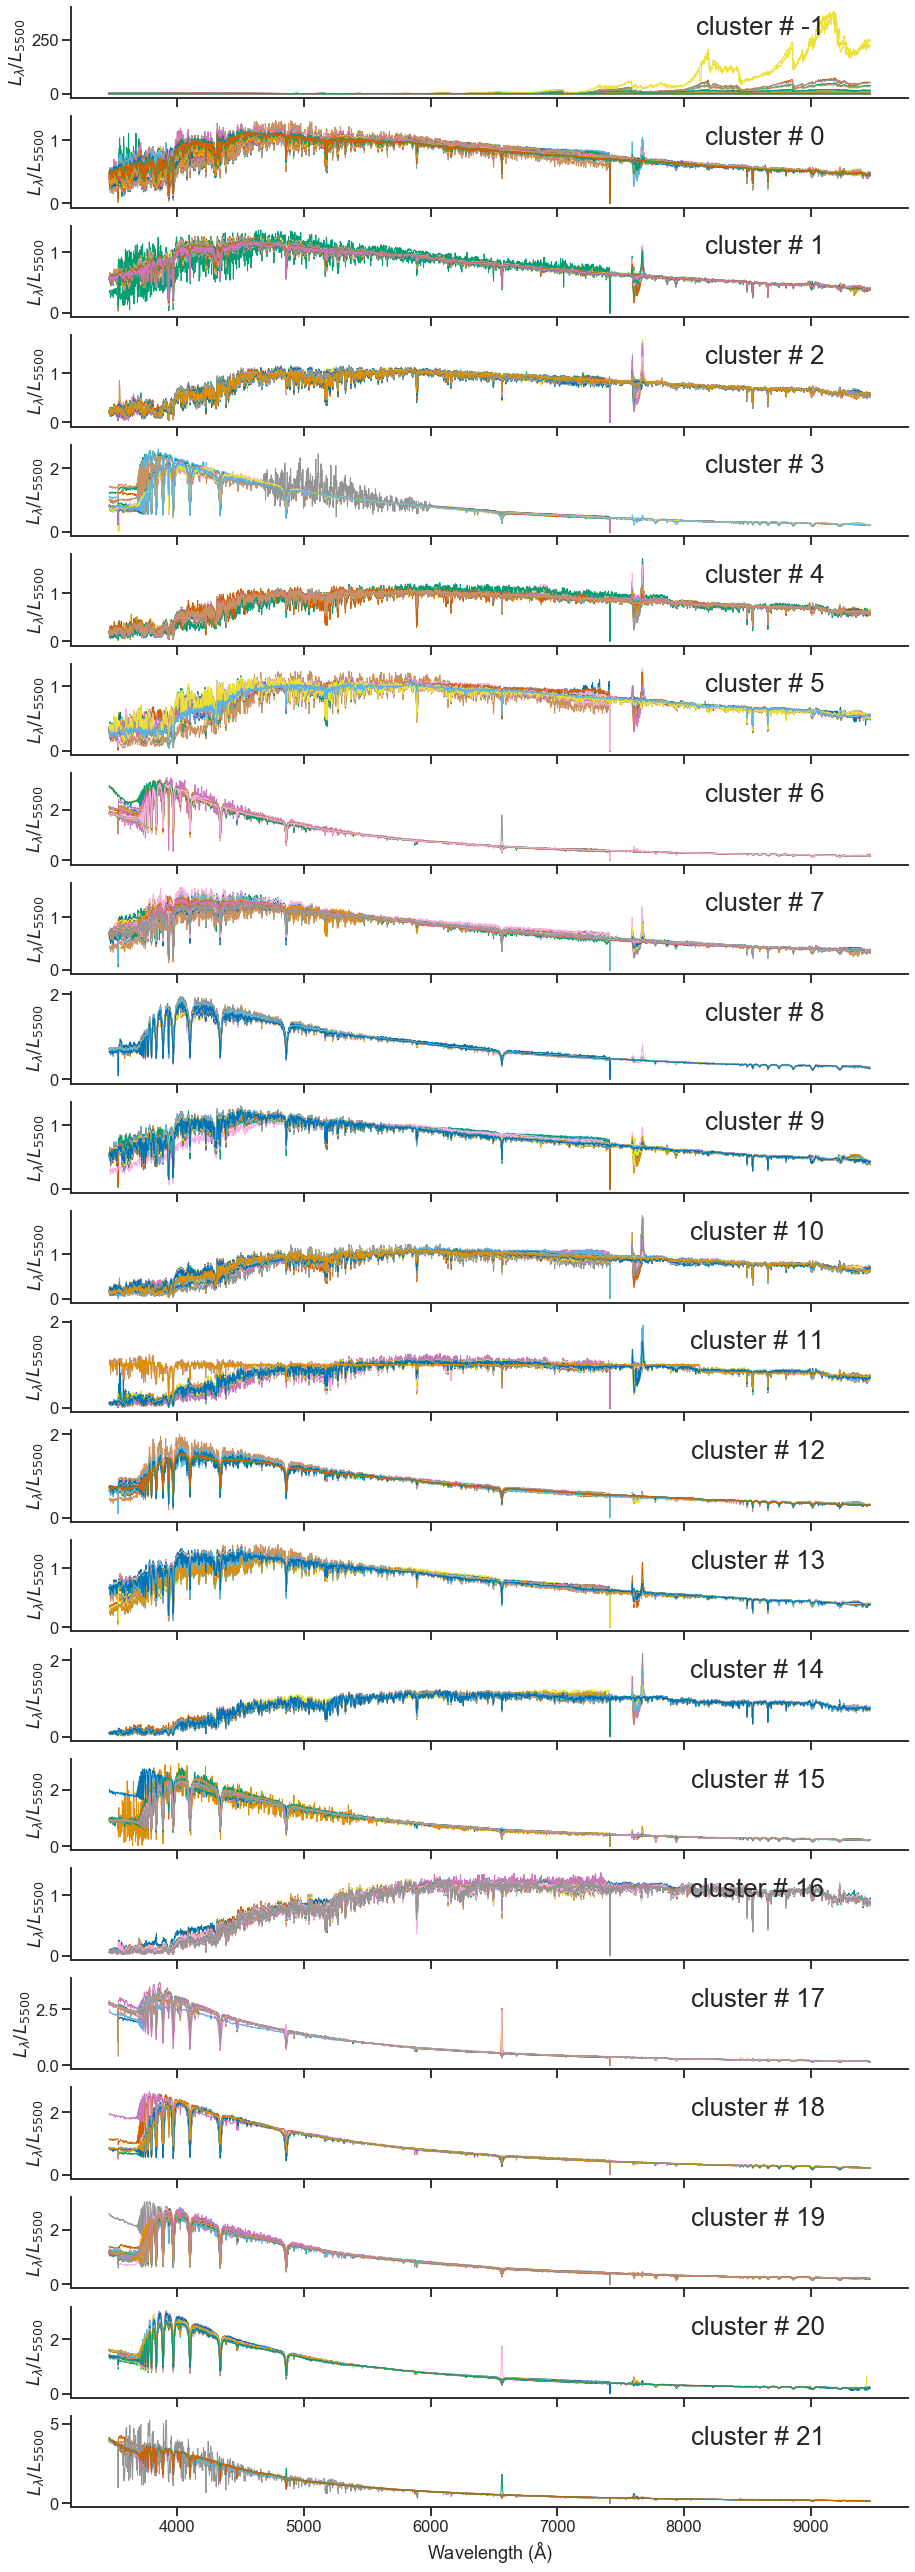

In [28]:
fig, axs = plt.subplots(i_clusters.size, 1, figsize=(15,2*i_clusters.size), sharex=True, sharey=False)

for i, ax in enumerate(axs):
    sample_cluster = X_cluster.loc[X_cluster.label==i_clusters[i]]
    
    ax.text(0.9, 0.9, f"cluster # {i_clusters[i]}", ha="right", va="top", fontsize="x-large", transform=ax.transAxes)
    for j, ised in enumerate(sample_cluster.transpose()):
        ax.plot(X.columns.values, X.loc[ised].values, lw=1)
    
    ax.set_ylabel(r"$L_\lambda/L_{5500}$")
    if ax.is_last_row():
        ax.set_xlabel(r"Wavelength (${\rm \AA}$)")
        
sns.despine()
fig.savefig(os.path.join(IMG_PATH, "stellar-spectra-clusters.png"), bbox_inches="tight")

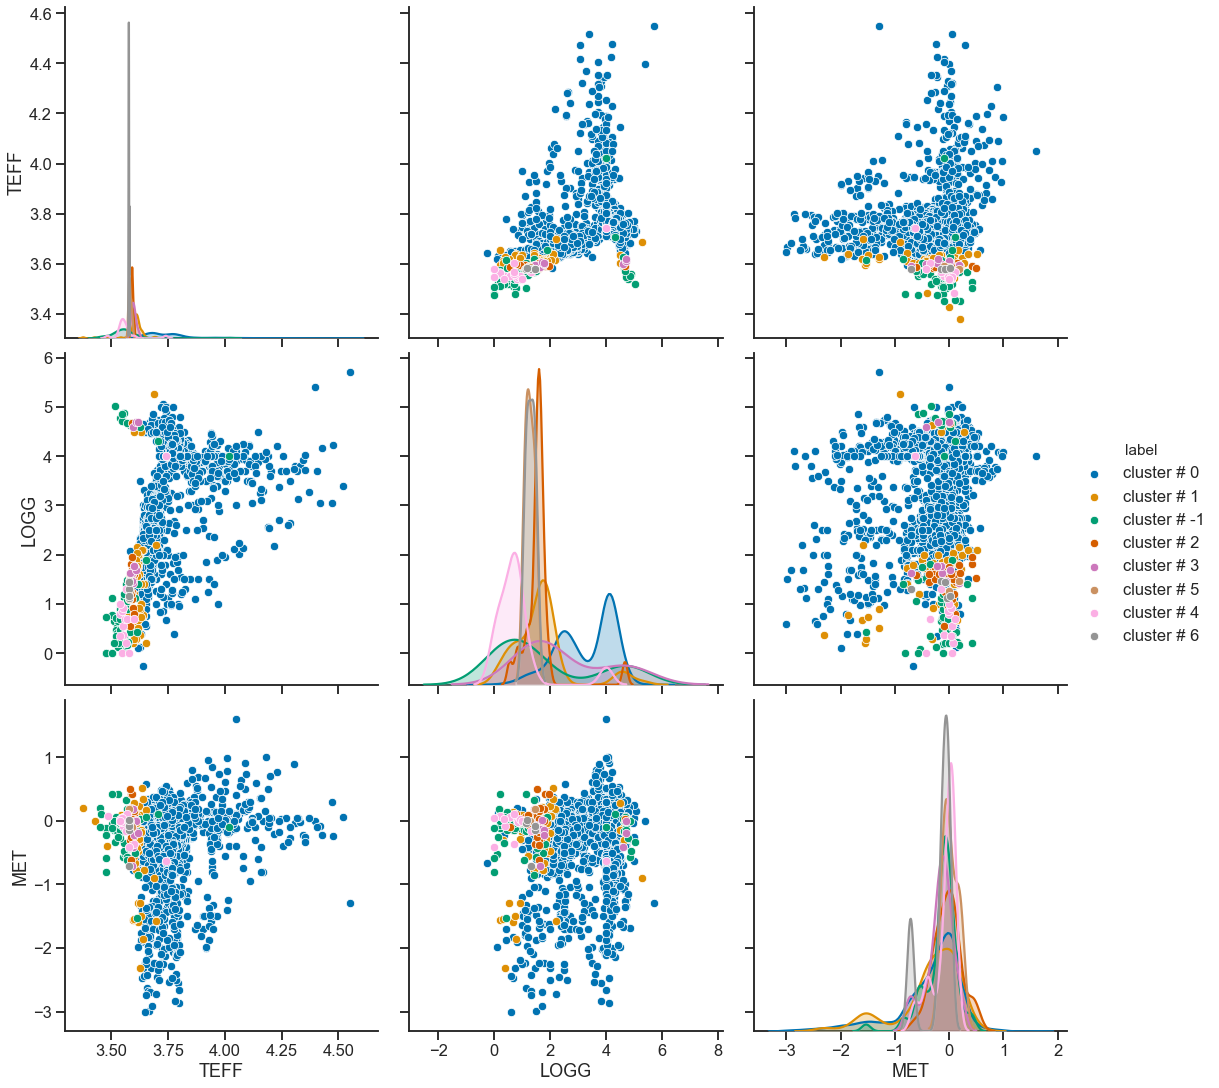

In [10]:
g = sns.pairplot(y_cluster, hue="label", height=5, plot_kws={"s": 70})

# g = sns.PairGrid(y_cluster, diag_sharey=False, hue="label", height=5)
# g.map_diag(sns.kdeplot)
# g.map_lower(sns.kdeplot)
# for i, j in zip(*np.triu_indices_from(g.axes, 1)):
#     g.axes[i, j].set_visible(False)

g.fig.savefig(os.path.join(IMG_PATH, "stellar-params-clusters.png"), bbox_inches="tight")

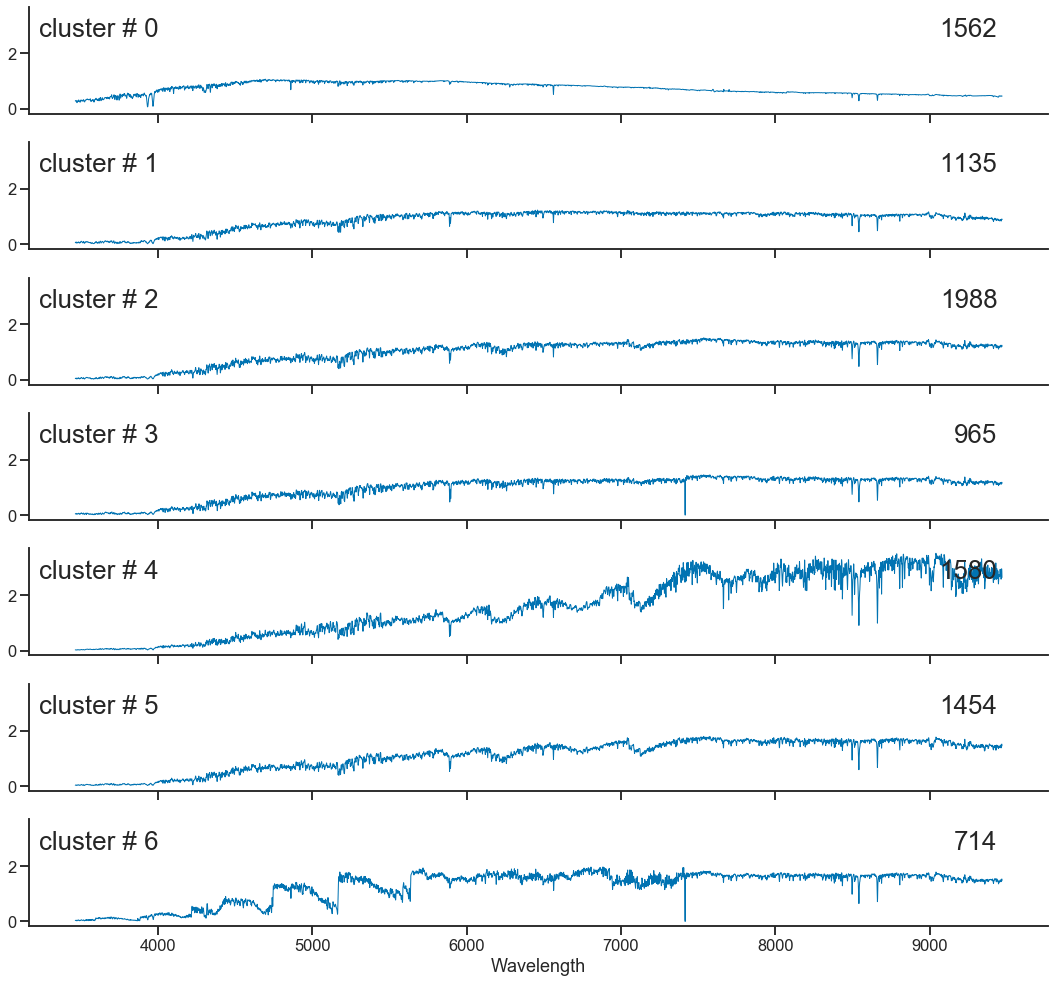

In [11]:
X_filtered = X.iloc[cluster_cent[1:], :]
y_filtered = y.iloc[cluster_cent[1:], :]

fig, axs = plt.subplots(X_filtered.shape[0], 1, figsize=(15,2*X_filtered.shape[0]), sharex=True, sharey=True)
for i, ax in enumerate(axs):
    sed = X_filtered.iloc[i]
    
    ax.text(0.01, 0.9, f"cluster # {i_clusters[1:][i]}", ha="left", va="top", fontsize="x-large", transform=ax.transAxes)
    ax.text(0.95, 0.9, sed.name, ha="right", va="top", fontsize="x-large", transform=ax.transAxes)
    ax.plot(sed.index.values, sed.values, lw=1)

ax.set_xlabel("Wavelength")

sns.despine()
fig.tight_layout()
fig.savefig(os.path.join(IMG_PATH, "stellar-base.png"), bbox_inches="tight")

In [12]:
# from astropy.io import fits


# path = "/home/mejia/Research/UNAM/pyFIT3D/ancillary_data/gsd01_156.fits"

# f = fits.open(path)

# nwl = f[0].header["NAXIS1"]
# nsp = f[0].header["NAXIS2"]

# wlength = np.array([f[0].header["CRVAL1"] + f[0].header["CDELT1"]*i for i in range(nwl)])

# wl_nor = f[0].header["WAVENORM"]
# fl_nor = np.zeros(nsp)
# age, met = np.zeros(nsp), np.zeros(nsp)
# for ised in range(nsp):
#     name = f[0].header[f"NAME{ised}"].split("_")
    
#     age_str = name[2].strip("Gyr")
#     age[ised] = float(age_str)*1e9
    
#     met_str = name[3].strip("z").strip(".dat")
#     met[ised] = float(f"{met_str[0]}.{met_str[1:]}")
    
#     fl_nor[ised] = f[0].header[f"NORM{ised}"]
    
# ssp_seds = f[0].data * fl_nor[:, None]

In [13]:
from astropy.io import fits
from itertools import combinations


N_BINS = 20
hdu_imaxes = list(combinations(y.columns, 2))

header = fits.Header([
    ("NCLUSTER", len(i_clusters[1:]), "Number of clusters"),
    ("COMMENT", "The number of clusters refers to the minimum number of stellar spectra that are distinguishable from one another")
])
primary_hdu = fits.PrimaryHDU(header=header)

hdu_list = fits.HDUList([primary_hdu])
for name_x, name_y in hdu_imaxes:
    x_lims, y_lims = y.describe().loc[["min","max"], (name_x,name_y)].values.T
    
    pdf_cube = []
    for i in i_clusters[1:]:
        data = y_cluster.loc[y_cluster.label==f"cluster # {i}"]
        
        x_, y_ = data[name_x], data[name_y]
        
        pdf_xy, xe, ye = np.histogram2d(x_, y_, bins=N_BINS, range=(x_lims,y_lims), density=True)
        
        xdelt, ydelt = np.diff(xe)[0], np.diff(ye)[0]
        xc = xe[:-1] + xdelt*0.5
        yc = ye[:-1] + ydelt*0.5
        pdf_cube.append(pdf_xy)
        
    ext_hdu = fits.ImageHDU(
        data=np.dstack(pdf_cube),
        header=fits.Header([
            ("LABEL_X", name_x),
            ("LABEL_Y", name_y),
            ("CRVAL1", xc[0]),
            ("CDELT1", xdelt),
            ("CRVAL2", yc[0]),
            ("CDELT2", ydelt)
        ])
    )
    hdu_list.append(ext_hdu)

# hdu_list.writeto("stellar_basis.fits", overwrite=True)

In [14]:
# for model_name in tqdm(X_filtered.index, desc="writing models", unit="SED"):
#     wl, fl = X_filtered.columns, X_filtered.loc[model_name]
#     np.savetxt(f"sed-tables/models/{model_name}.txt", np.column_stack((wl,fl)), header="wavelength flux")

# y_filtered.reset_index().to_csv(f"sed-tables/models-params.csv", index=False)